<a href="https://colab.research.google.com/github/Anjan-AI/TSAI-EVA5/blob/master/Session%206%20-%20Batch%20Normalization%20and%20Regularization/Eva5_session_6_GBN_L1_L2_Regularization_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Session 6 
study the Impact of differnt regularization technique 
1. Ghost Batch Normalization
2. GBN + L1
3. GBN + L2
4. GBN + L1 L2

# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-12.0, 12.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


TypeError: ignored

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

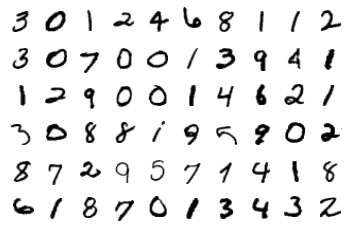

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Ghost Normalization 

In [26]:
# Ghost Noramlization
class GhostBatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


# The model
Let's start with the model we first saw

In [40]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10),
            GhostBatchNorm(num_features =10, num_splits=2),
            nn.Dropout(dropout_value)
        ) # output_size = 28  RF : 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(24),
            GhostBatchNorm(num_features =24, num_splits=2),
            nn.Dropout(dropout_value)
        ) # output_size = 26   RF : 5

          # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU() 
        )  # output_size = 26  RF 5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 13  RF 6

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
           # nn.BatchNorm2d(10),
            GhostBatchNorm(num_features =10, num_splits=2),
            nn.Dropout(dropout_value)
        ) # output_size = 13   RF : 10

        self.convblock41 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16),
            GhostBatchNorm(num_features =16, num_splits=2),
            nn.Dropout(dropout_value)
        ) #output_size = 11  RF : 14
       
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 9  RF :18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            #nn.BatchNorm2d(16),
            GhostBatchNorm(num_features =16, num_splits=2),
            nn.Dropout(dropout_value)
        ) # output_size = 7 RF 22

        
        self.gap1 = nn.Sequential(
            nn.AvgPool2d(kernel_size =(7,7))
        ) # output_size = 1  RF 34
        #  # Output BLOCK 
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
          
        ) # output_size = 1  RF 34
       

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock41(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap1(x)
        x = self.convblock7(x)
        
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [41]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
    GhostBatchNorm-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 24, 26, 26]           2,160
              ReLU-6           [-1, 24, 26, 26]               0
    GhostBatchNorm-7           [-1, 24, 26, 26]              48
           Dropout-8           [-1, 24, 26, 26]               0
            Conv2d-9           [-1, 10, 26, 26]             240
             ReLU-10           [-1, 10, 26, 26]               0
        MaxPool2d-11           [-1, 10, 13, 13]               0
           Conv2d-12           [-1, 10, 13, 13]             900
             ReLU-13           [-1, 10, 13, 13]               0
   GhostBatchNorm-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [73]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch,l1_factor, train_losses, train_acc ):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    #implement L1 Loss if l1_factor >0
    if l1_factor > 0:  # Apply L1 regularization
            l1_criteria = nn.L1Loss(size_average=False)
            regularizer_loss = 0
            for parameter in model.parameters():
                regularizer_loss += l1_criteria(parameter, torch.zeros_like(parameter))
            loss += l1_factor * regularizer_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,test_losses,test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Function to get the Misclassfied Images & Plot it

In [21]:
def getmissclassifiedImage(model, device, test_loader):
  misclassified = []
  misclassified_pred = []
  misclassified_target = []
  misclassfiled_list = []
  model.eval()

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
     
      output = model(data)
      pred = output.argmax(dim =1, keepdim =True)
      
      list_misclassified = (pred.eq(target.view_as(pred)) == False)
      batch_misclassified = data[list_misclassified]
      batch_mis_pred = pred[list_misclassified]
      batch_mis_target = target.view_as(pred)[list_misclassified]

      misclassified.append(batch_misclassified)
      misclassified_pred.append(batch_mis_pred)
      misclassified_target.append(batch_mis_target)
                                  
  # group all the batched together
  
  misclassified = torch.cat(misclassified)
  misclassified_pred = torch.cat(misclassified_pred)
  misclassified_target = torch.cat(misclassified_target)  
                                
 
  misclassfiled_list.append(misclassified)
  misclassfiled_list.append(misclassified_pred)
  misclassfiled_list.append(misclassified_pred)

  return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))



In [44]:
import random
def Plot_misclassifed(model, device, test_loader):
 misclassified = getmissclassifiedImage(model, device, test_loader)
 num_images = 25
 fig = plt.figure(figsize=(12, 12))
 for idx, (image, pred, target) in enumerate(random.choices(misclassified, k=num_images)):
     image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu()
     ax = fig.add_subplot(5, 5, idx+1)
     ax.axis('off')
     ax.set_title('target {}\npred {}'.format(target.item(), pred.item()), fontsize=12)
     ax.imshow(image.squeeze())
 plt.show()

# Let's Train and test our model

In [74]:

def runmodel(l1_factor,l2_factor,train_losses,train_acc,test_losses,test_acc):
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=l2_factor)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.1)    
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch,l1_factor,train_losses,train_acc)
      scheduler.step()
      test(model, device, test_loader,test_losses,test_acc)
  Plot_misclassifed(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

PROCESSING GBN ONLY
EPOCH: 0


Loss=0.18047410249710083 Batch_id=468 Accuracy=83.97: 100%|██████████| 469/469 [00:12<00:00, 36.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0908, Accuracy: 9746/10000 (97.46%)

EPOCH: 1


Loss=0.12348674982786179 Batch_id=468 Accuracy=96.70: 100%|██████████| 469/469 [00:13<00:00, 35.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0813, Accuracy: 9795/10000 (97.95%)

EPOCH: 2


Loss=0.11423876881599426 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:13<00:00, 35.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0648, Accuracy: 9817/10000 (98.17%)

EPOCH: 3


Loss=0.04920798912644386 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:13<00:00, 35.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9902/10000 (99.02%)

EPOCH: 4


Loss=0.03490089252591133 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:12<00:00, 36.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9915/10000 (99.15%)

EPOCH: 5


Loss=0.13153091073036194 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:13<00:00, 34.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


Loss=0.006808679085224867 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:13<00:00, 35.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9922/10000 (99.22%)

EPOCH: 7


Loss=0.041187189519405365 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:13<00:00, 35.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.03174455836415291 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 34.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.034367647022008896 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 35.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.020820844918489456 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 35.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.008560949936509132 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:12<00:00, 36.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.11681094020605087 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.049362313002347946 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:12<00:00, 36.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.020674122497439384 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:13<00:00, 36.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.01762200891971588 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 35.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.10400882363319397 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:12<00:00, 36.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9930/10000 (99.30%)

EPOCH: 17


Loss=0.014573133550584316 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:12<00:00, 36.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.017653262242674828 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:13<00:00, 35.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.04752082750201225 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:13<00:00, 35.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9929/10000 (99.29%)

EPOCH: 20


Loss=0.05375383794307709 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:12<00:00, 36.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9927/10000 (99.27%)

EPOCH: 21


Loss=0.07441569864749908 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 35.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9931/10000 (99.31%)

EPOCH: 22


Loss=0.1325705200433731 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 34.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9931/10000 (99.31%)

EPOCH: 23


Loss=0.022216953337192535 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:12<00:00, 36.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9927/10000 (99.27%)

EPOCH: 24


Loss=0.03461669385433197 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:13<00:00, 35.29it/s]



Test set: Average loss: 0.0227, Accuracy: 9933/10000 (99.33%)



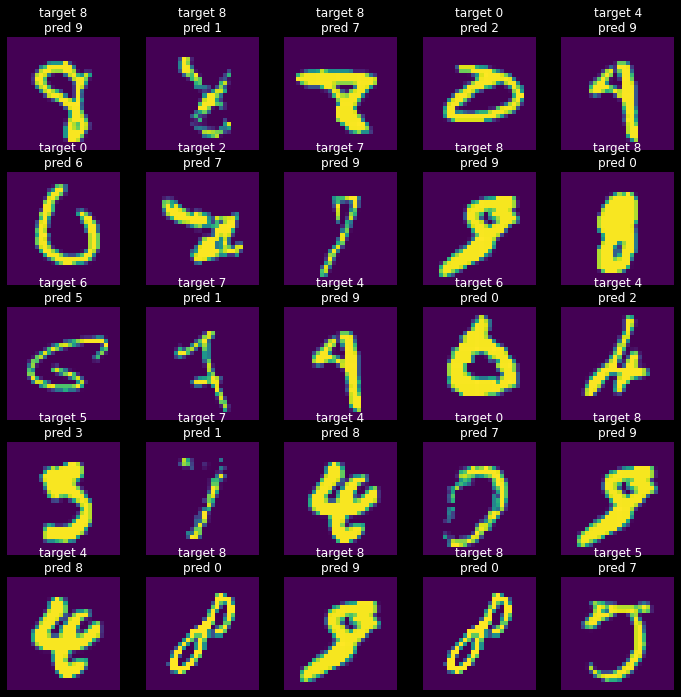

In [102]:
# GBN only 
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)

EPOCHS = 25

print("PROCESSING GBN ONLY")
l1_factor =0
l2_factor =0
train_losses_GBN = []
test_losses_GBN = []
train_acc_GBN = []
test_acc_GBN = []
runmodel(l1_factor,l2_factor,train_losses_GBN,train_acc_GBN,test_losses_GBN,test_acc_GBN)


PROCESSING GBN + L1 ONLY


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.18642458319664001 Batch_id=468 Accuracy=81.08: 100%|██████████| 469/469 [00:15<00:00, 31.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1437, Accuracy: 9585/10000 (95.85%)

EPOCH: 1


Loss=0.12490209937095642 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9846/10000 (98.46%)

EPOCH: 2


Loss=0.19359531998634338 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:14<00:00, 31.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9860/10000 (98.60%)

EPOCH: 3


Loss=0.1077648401260376 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:15<00:00, 31.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9897/10000 (98.97%)

EPOCH: 4


Loss=0.19077476859092712 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:15<00:00, 30.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


Loss=0.11693474650382996 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 31.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9891/10000 (98.91%)

EPOCH: 6


Loss=0.10759654641151428 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.12009947001934052 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 31.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.10125140845775604 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 31.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.09427255392074585 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 31.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.14082850515842438 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.0972183346748352 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.0896657258272171 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:15<00:00, 31.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.1020897775888443 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:15<00:00, 31.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.10841746628284454 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:14<00:00, 31.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.14062905311584473 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:15<00:00, 30.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.09821123629808426 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.20054614543914795 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:15<00:00, 30.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Loss=0.07588779926300049 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:15<00:00, 31.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.06970637291669846 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9930/10000 (99.30%)

EPOCH: 20


Loss=0.13622945547103882 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:15<00:00, 30.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.07960578799247742 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.1019403487443924 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:15<00:00, 30.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9929/10000 (99.29%)

EPOCH: 23


Loss=0.09551934897899628 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9934/10000 (99.34%)

EPOCH: 24


Loss=0.11599621176719666 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:15<00:00, 30.72it/s]



Test set: Average loss: 0.0194, Accuracy: 9934/10000 (99.34%)



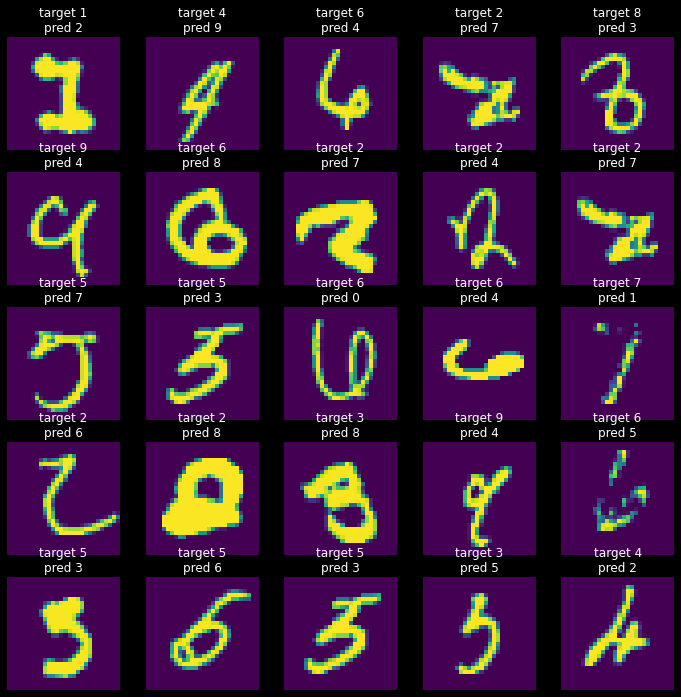

In [103]:
# GBN + L1 
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)

EPOCHS = 25

print("PROCESSING GBN + L1 ONLY")
l1_factor =0.0001
l2_factor =0
train_losses_GBN_L1 = []
test_losses_GBN_L1 = []
train_acc_GBN_L1 = []
test_acc_GBN_L1 = [] 
runmodel(l1_factor,l2_factor,train_losses_GBN_L1,train_acc_GBN_L1,test_losses_GBN_L1,test_acc_GBN_L1)  
 

  0%|          | 0/469 [00:00<?, ?it/s]

PROCESSING GBN + L2 ONLY
EPOCH: 0


Loss=0.14853838086128235 Batch_id=468 Accuracy=84.19: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0909, Accuracy: 9755/10000 (97.55%)

EPOCH: 1


Loss=0.09313195198774338 Batch_id=468 Accuracy=96.69: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0685, Accuracy: 9790/10000 (97.90%)

EPOCH: 2


Loss=0.019725196063518524 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:13<00:00, 34.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9871/10000 (98.71%)

EPOCH: 3


Loss=0.0416967011988163 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:13<00:00, 35.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9891/10000 (98.91%)

EPOCH: 4


Loss=0.03969816491007805 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:13<00:00, 34.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9882/10000 (98.82%)

EPOCH: 5


Loss=0.06009678915143013 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:12<00:00, 36.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.036406259983778 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:13<00:00, 35.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.02718803845345974 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:13<00:00, 34.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.0788176879286766 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:13<00:00, 35.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.06954994052648544 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:13<00:00, 34.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9927/10000 (99.27%)

EPOCH: 10


Loss=0.02450898103415966 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:13<00:00, 34.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.017121324315667152 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:12<00:00, 36.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.040005821734666824 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:13<00:00, 35.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.05393008887767792 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:12<00:00, 36.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.08383172750473022 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:13<00:00, 35.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.12666286528110504 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 35.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.021456370130181313 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:12<00:00, 36.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.023006722331047058 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 35.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Loss=0.056500453501939774 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:12<00:00, 36.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

EPOCH: 19


Loss=0.08346845954656601 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9937/10000 (99.37%)

EPOCH: 20


Loss=0.05976669117808342 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:12<00:00, 36.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

EPOCH: 21


Loss=0.0528116412460804 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:12<00:00, 36.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.029229693114757538 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:12<00:00, 36.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Loss=0.02467157691717148 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 35.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9936/10000 (99.36%)

EPOCH: 24


Loss=0.009734510444104671 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:12<00:00, 36.52it/s]



Test set: Average loss: 0.0215, Accuracy: 9938/10000 (99.38%)



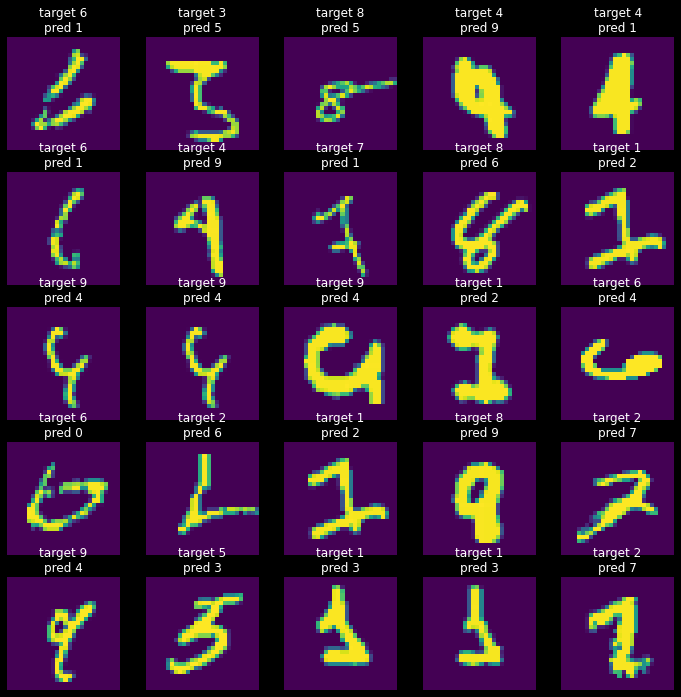

In [104]:
# GBN + L2
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)

EPOCHS = 25

print("PROCESSING GBN + L2 ONLY")
l1_factor =0
l2_factor =0.0001
train_losses_GBN_L2 = []
test_losses_GBN_L2 = []
train_acc_GBN_L2 = []
test_acc_GBN_L2 = []
runmodel(l1_factor,l2_factor,train_losses_GBN_L2,train_acc_GBN_L2,test_losses_GBN_L2,test_acc_GBN_L2)


PROCESSING GBN + L1 & L2 


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.16019102931022644 Batch_id=468 Accuracy=82.96: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1007, Accuracy: 9710/10000 (97.10%)

EPOCH: 1


Loss=0.2041849046945572 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9855/10000 (98.55%)

EPOCH: 2


Loss=0.12457913160324097 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0629, Accuracy: 9809/10000 (98.09%)

EPOCH: 3


Loss=0.08235965669155121 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:15<00:00, 31.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.14414605498313904 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:15<00:00, 30.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9878/10000 (98.78%)

EPOCH: 5


Loss=0.11283297836780548 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:15<00:00, 29.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.0753641277551651 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.09321063756942749 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:15<00:00, 30.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.08588720858097076 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.11228834092617035 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 31.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.15011289715766907 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.18017229437828064 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 31.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.10233493149280548 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 30.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.12528587877750397 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:15<00:00, 30.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.0832730382680893 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:15<00:00, 30.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.11408089101314545 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:14<00:00, 31.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Loss=0.07779529690742493 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 30.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9926/10000 (99.26%)

EPOCH: 17


Loss=0.12552808225154877 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:15<00:00, 30.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.06455040723085403 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9927/10000 (99.27%)

EPOCH: 19


Loss=0.0996018648147583 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:14<00:00, 31.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.1448986530303955 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:15<00:00, 31.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9925/10000 (99.25%)

EPOCH: 21


Loss=0.1041298657655716 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 30.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.11696942895650864 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:15<00:00, 30.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9929/10000 (99.29%)

EPOCH: 23


Loss=0.13003891706466675 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:15<00:00, 31.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

EPOCH: 24


Loss=0.10565195232629776 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 30.83it/s]



Test set: Average loss: 0.0246, Accuracy: 9925/10000 (99.25%)



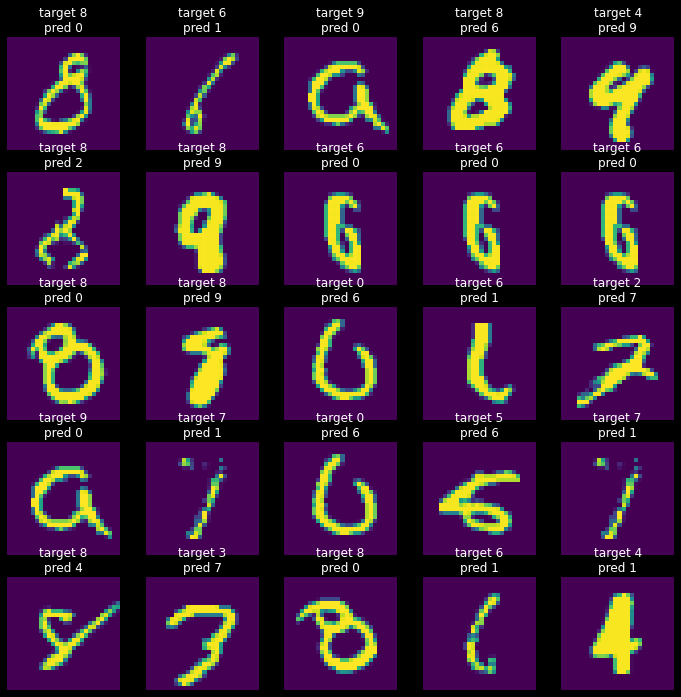

In [105]:
# GBN + L1 L2
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)

EPOCHS = 25
print("PROCESSING GBN + L1 & L2 ")
l1_factor =0.0001
l2_factor =0.0001
train_losses_GBN_L12 = []
test_losses_GBN_L12 = []
train_acc_GBN_L12 = []
test_acc_GBN_L12 = []
runmodel(l1_factor,l2_factor,train_losses_GBN_L12,train_acc_GBN_L12,test_losses_GBN_L12,test_acc_GBN_L12)

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_metric(GBN, l1, l2, l1_l2, metric):
    # Initialize a figure
    plt.style.use("dark_background")
    fig = plt.figure(figsize=(11, 9))
    
    # Plot values
    GBN_plt, = plt.plot(GBN)
    l1_plt, = plt.plot(l1)
    l2_plt, = plt.plot(l2)
    l1_l2_plt, = plt.plot(l1_l2)

    # Set plot title
    plt.title(f'Validation {metric}')

    # Label axes
    plt.xlabel('Epoch')
    plt.ylabel(metric)

    # Set legend
    location = 'upper' if ((metric == 'Test loss') or (metric == 'Train loss')) else 'lower'
    plt.legend(
        (GBN_plt, l1_plt, l2_plt, l1_l2_plt),
        ('GBN', 'L1', 'L2', 'L1 + L2'),
        loc=f'{location} right',
        shadow=True,
        prop={'size': 10}
    )

    # Save plot
    fig.savefig(f'{metric.lower()}_change.png')

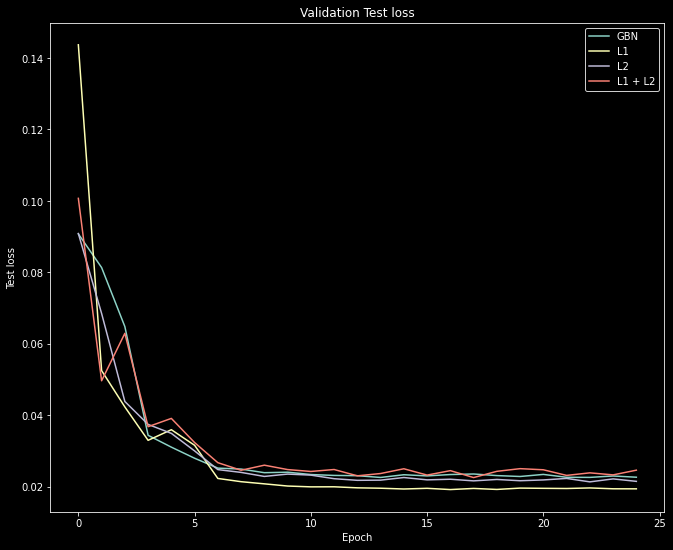

In [107]:
plot_metric(test_losses_GBN, test_losses_GBN_L1, test_losses_GBN_L2, test_losses_GBN_L12, 'Test loss')


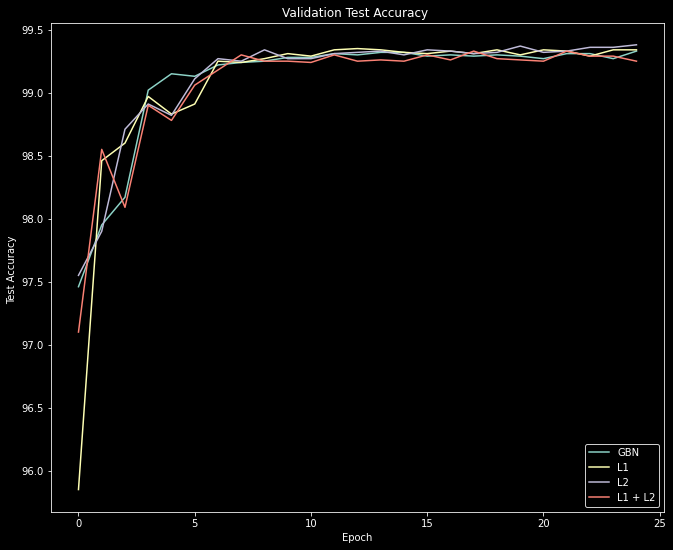

In [108]:
plot_metric(test_acc_GBN, test_acc_GBN_L1, test_acc_GBN_L2, test_acc_GBN_L12, 'Test Accuracy ')


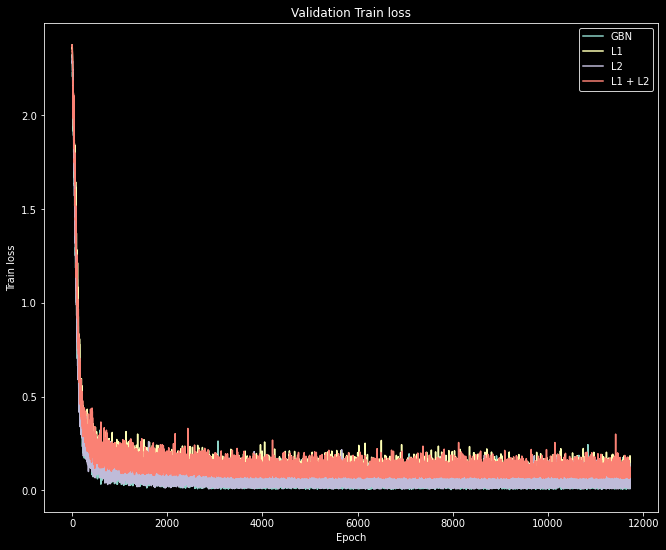

In [109]:
plot_metric(train_losses_GBN, train_losses_GBN_L1, train_losses_GBN_L2, train_losses_GBN_L12, 'Train loss')


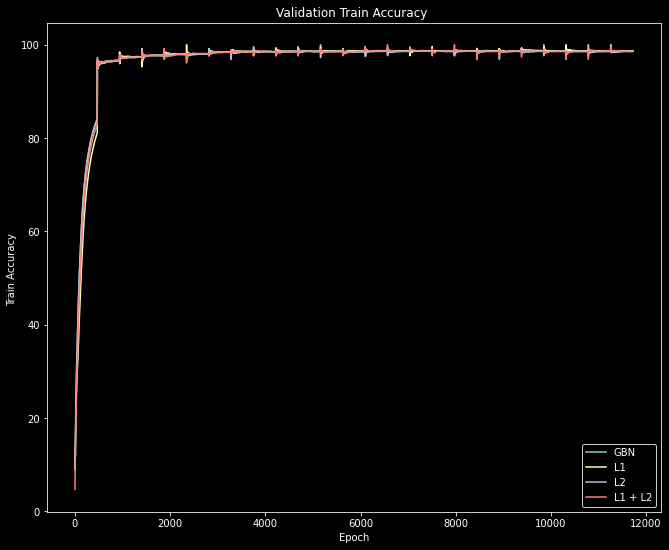

In [110]:
plot_metric(train_acc_GBN, train_acc_GBN_L1, train_acc_GBN_L2, train_acc_GBN_L12, 'Train Accuracy ')